#  Titanic Notebook

## Introduction

### Understand the problem

RMS Titanic was a British ship that sank in 1912 in the Atlantic Ocean. Over 1,500 passengers did not survive this collision. As you can see, there was a correlation between those who survived and the conditions in which they were. 
In this notebook I will try to examine and visualize the data to understand the problem and find the best algorithm for predicting whether the passenger will survive. I'm going to use tools which i already learned. This is my first notebook, so any comments are welcome. :)

### Import required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


## Data exploration, preprocessing and visualization

In [2]:
data_train = pd.read_csv("Data/train.csv")
data_test = pd.read_csv("Data/test.csv")
alldata = pd.DataFrame
alldata = alldata.append(data_train, data_test, sort=False)

### Data exploration

At first let's see data attributes and describe them.

In [3]:
data_train.keys()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Variable|	Definition	|Key
--------|---------------|---------------
Survival|	Survival	|0 = No, 1 = Yes
Pclass	|Ticket class	|1 = 1st, 2 = 2nd, 3 = 3rd
Sex	    |Sex	        | male, female
Age	    |Age in years	|
Sibsp	|# of siblings(spouses) on the Titanic  |	
  Parch	|# of parents(children) on the Titanic |
Ticket	|Ticket number	
Fare	|Passenger fare	
Cabin	|Cabin number	
Embarked|	Port of Embarkation|	C = Cherbourg, Q = Queenstown, S = Southampton


In [4]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can see that some features is catgorical and com features are numerical.
Now we will change some categorical features (like Sex, Embarked, Cabin) to numerical. Then we will deal with missing values. But first we need more information about features.

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


We can notice that we miss some values, so we need to take care about that!

### Data preprocessing

Now we need to change some data type and clean them.

In [6]:
data_train = data_train.dropna(subset=["Embarked"])
data_test = data_test.dropna(subset=["Embarked"])

data_train['Has_Cabin'] = data_train['Cabin'].apply(lambda x:0 if type(x) == float else 1)
data_test['Has_Cabin'] = data_test['Cabin'].apply(lambda x:0 if type(x) == float else 1)

data_train['Sex'] = data_train['Sex'].map({'male': 1, 'female': 0})
data_test['Sex'] = data_test['Sex'].map({'male': 1, 'female': 0})

data_train['NFamily'] = data_train.SibSp + data_train.Parch + 1
data_test['NFamily'] = data_test.SibSp + data_train.Parch + 1

mean_age = data_train.Age.mean()
data_train['Age'] = data_train['Age'].fillna(mean_age)
data_test['Age'] = data_test['Age'].fillna(mean_age)

data_train['Embarked'] = data_train['Embarked'].map({'S':0, 'C':1, 'Q':2})
data_test['Embarked'] = data_test['Embarked'].map({'S':0, 'C':1, 'Q':2})

data_test['NFamily'] = data_test['NFamily'].fillna(data_test['NFamily'].median())
data_test['Fare'] = data_test['Fare'].fillna(data_test['Fare'].mean())

data_train['Title'] = data_train.Name.apply(lambda x: x.split(",")[1].split('.')[0].lower().lstrip())
data_test['Title'] = data_test.Name.apply(lambda x: x.split(",")[1].split('.')[0].lower().lstrip())

popular_titles = ['mr', 'miss', 'mrs', 'master', 'dr', 'rev']
data_train.Title = data_train.Title.map(lambda x: x if x in popular_titles else 'other')
data_test.Title = data_test.Title.map(lambda x: x if x in popular_titles else 'other')

titles_map = {'mr': 1, 'miss': 2, 'mrs': 3, 'master':4, 'dr':5, 'rev':6, 'other': 7}
data_train.Title = data_train.Title.map(titles_map)
data_test.Title = data_test.Title.map(titles_map)

data_train.Ticket = data_train.Ticket.apply(lambda x: x.split(' '))
data_train.Ticket = data_train.Ticket.apply(lambda x: 1 if len(x) == 1 else 2)
data_test.Ticket = data_test.Ticket.apply(lambda x: x.split(' '))
data_test.Ticket = data_test.Ticket.apply(lambda x: 1 if len(x) == 1 else 2)

data_train['Cabin_type'] = data_train.Cabin.apply(lambda x: str(x)[0] if str(x) != 'nan' else 'nan')
data_test['Cabin_type'] = data_test.Cabin.apply(lambda x: str(x)[0] if str(x) != 'nan' else 'nan')
ck = {'A': 3, 'B': 1, 'C':2, 'D':1, 'E':1, 'F':3,'G':3, 'nan':4, 'T':4}
data_train.Cabin_type = data_train.Cabin_type.map(ck)
data_test.Cabin_type = data_test.Cabin_type.map(ck)

data_train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,NFamily,Title,Cabin_type
194,195,1,1,"Brown, Mrs. James Joseph (Margaret Tobin)",0,44.000000,0,0,2,27.7208,B4,1,1,1,3,1
262,263,0,1,"Taussig, Mr. Emil",1,52.000000,1,1,1,79.6500,E67,0,1,3,1,1
218,219,1,1,"Bazzani, Miss. Albina",0,32.000000,0,0,1,76.2917,D15,1,1,1,2,1
773,774,0,3,"Elias, Mr. Dibo",1,29.642093,0,0,1,7.2250,NaN,1,0,1,1,4
782,783,0,1,"Long, Mr. Milton Clyde",1,29.000000,0,0,1,30.0000,D6,0,1,1,1,1
878,879,0,3,"Laleff, Mr. Kristo",1,29.642093,0,0,1,7.8958,NaN,0,0,1,1,4
269,270,1,1,"Bissette, Miss. Amelia",0,35.000000,0,0,2,135.6333,C99,0,1,1,2,2
493,494,0,1,"Artagaveytia, Mr. Ramon",1,71.000000,0,0,2,49.5042,NaN,1,0,1,1,4
460,461,1,1,"Anderson, Mr. Harry",1,48.000000,0,0,1,26.5500,E12,0,1,1,1,1
866,867,1,2,"Duran y More, Miss. Asuncion",0,27.000000,1,0,2,13.8583,NaN,1,0,2,2,4


In [7]:

data_train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,NFamily,Title,Cabin_type
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",1,80.000000,0,0,1,30.0000,A23,0,1,1,1,3
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",0,4.000000,1,1,2,16.7000,G6,0,1,3,2,3
841,842,0,2,"Mudd, Mr. Thomas Charles",1,16.000000,0,0,2,10.5000,NaN,0,0,1,1,4
544,545,0,1,"Douglas, Mr. Walter Donald",1,50.000000,1,0,2,106.4250,C86,1,1,2,1,2
83,84,0,1,"Carrau, Mr. Francisco M",1,28.000000,0,0,1,47.1000,NaN,0,0,1,1,4
877,878,0,3,"Petroff, Mr. Nedelio",1,19.000000,0,0,1,7.8958,NaN,0,0,1,1,4
502,503,0,3,"O'Sullivan, Miss. Bridget Mary",0,29.642093,0,0,1,7.6292,NaN,2,0,1,2,4
43,44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",0,3.000000,1,2,2,41.5792,NaN,1,0,4,2,4
729,730,0,3,"Ilmakangas, Miss. Pieta Sofia",0,25.000000,1,0,2,7.9250,NaN,0,0,2,2,4
445,446,1,1,"Dodge, Master. Washington",1,4.000000,0,2,1,81.8583,A34,0,1,3,4,3


### Data visualization and exloration 

In this moment we have well prepared features. We can continue explore features and start visualizing them. This will help us to find more correlation between features and better understand data. At first let's check correlation between data then we will more precisely describe prepared features,

#### Let's get more info first

In [8]:
data_train.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Has_Cabin,NFamily,Title,Cabin_type
PassengerId,1.000000,-0.005028,-0.035330,0.043136,0.030335,-0.057686,-0.001657,-0.068584,0.012703,-0.030555,0.020045,-0.040258,0.020310,-0.051248
Survived,-0.005028,1.000000,-0.335549,-0.541585,-0.074513,-0.034040,0.083151,0.003008,0.255290,0.108669,0.313435,0.018277,0.373822,-0.326284
Pclass,-0.035330,-0.335549,1.000000,0.127741,-0.328256,0.081656,0.016824,-0.091101,-0.548193,0.043835,-0.723815,0.064221,-0.202609,0.714355
Sex,0.043136,-0.541585,0.127741,1.000000,0.089339,-0.116348,-0.247508,0.023362,-0.179958,-0.118593,-0.135589,-0.203191,-0.447336,0.154625
Age,0.030335,-0.074513,-0.328256,0.089339,1.000000,-0.231908,-0.178013,0.027535,0.088780,0.008940,0.228635,-0.247459,-0.059598,-0.237827
SibSp,-0.057686,-0.034040,0.081656,-0.116348,-0.231908,1.000000,0.414542,0.085562,0.160887,-0.060606,-0.038657,0.890654,0.219440,0.040029
Parch,-0.001657,0.083151,0.016824,-0.247508,-0.178013,0.414542,1.000000,0.040260,0.217532,-0.079320,0.039101,0.782988,0.256879,-0.036092
Ticket,-0.068584,0.003008,-0.091101,0.023362,0.027535,0.085562,0.040260,1.000000,0.182382,-0.076625,0.016325,0.078600,-0.003604,-0.026749
Fare,0.012703,0.255290,-0.548193,-0.179958,0.088780,0.160887,0.217532,0.182382,1.000000,0.063462,0.480425,0.218658,0.124104,-0.489553
Embarked,-0.030555,0.108669,0.043835,-0.118593,0.008940,-0.060606,-0.079320,-0.076625,0.063462,1.000000,0.016190,-0.081057,0.051471,-0.020266


In [9]:
data_train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Has_Cabin,NFamily,Title,Cabin_type
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,2.311586,0.649044,29.642093,0.524184,0.382452,1.254218,32.096681,0.362205,0.227222,1.906637,1.777278,3.460067
std,256.998173,0.486260,0.834700,0.477538,12.968346,1.103705,0.806761,0.435666,49.697504,0.636157,0.419273,1.614703,1.193970,1.060571
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,224.000000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,1.000000,7.895800,0.000000,0.000000,1.000000,1.000000,4.000000
50%,446.000000,0.000000,3.000000,1.000000,29.642093,0.000000,0.000000,1.000000,14.454200,0.000000,0.000000,1.000000,1.000000,4.000000
75%,668.000000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,2.000000,31.000000,1.000000,0.000000,2.000000,2.000000,4.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,2.000000,512.329200,2.000000,1.000000,11.000000,7.000000,4.000000


#### Here we can begin visualization

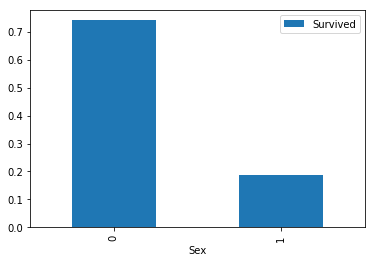

In [10]:
data_train[['Sex', 'Survived']].groupby('Sex').mean().plot(kind='Bar')

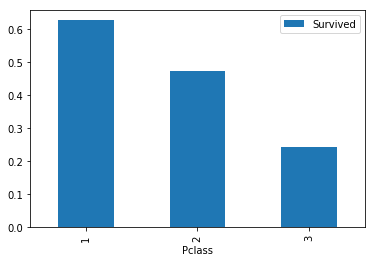

In [11]:
data_train[['Pclass', 'Survived']].groupby('Pclass').mean().plot(kind='Bar')

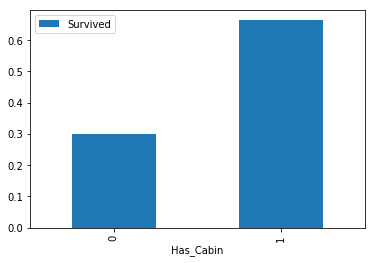

In [12]:
data_train[['Has_Cabin', 'Survived']].groupby('Has_Cabin').mean().plot(kind='Bar')

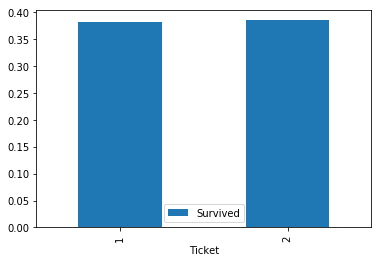

In [13]:
data_train[['Ticket', 'Survived']].groupby("Ticket").mean().plot(kind='Bar')

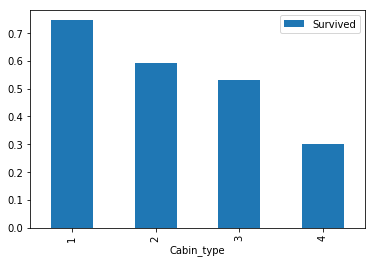

In [14]:
data_train[['Cabin_type', 'Survived']].groupby("Cabin_type").mean().plot(kind='Bar')

Now we drop useless features and scale them.

In [15]:
y = data_train['Survived']
dt_id = data_test['PassengerId']
data_train = data_train.drop(['Name', 'PassengerId', 'Cabin', 'Ticket', 'Survived', 'Embarked'], axis=1)
data_test = data_test.drop(['Name', 'PassengerId', 'Cabin', 'Ticket', 'Embarked', ], axis=1)
data_train.sample(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Has_Cabin,NFamily,Title,Cabin_type
500,3,1,17.000000,0,0,8.6625,0,1,1,4
795,2,1,39.000000,0,0,13.0000,0,1,1,4
388,3,1,29.642093,0,0,7.7292,0,1,1,4
584,3,1,29.642093,0,0,8.7125,0,1,1,4
641,1,0,24.000000,0,0,69.3000,1,1,7,1


## Selecting model

In this moment we know enough about our features. Now we can implement, train, and test our prediction model.

In [16]:

rf = RandomForestClassifier(max_depth=5)
rf.fit(data_train, y)
cross_val_score(rf, data_train, y, cv=3)


c:\users\michal\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0.78114478, 0.85810811, 0.82432432])

In [17]:
pred = rf.predict(data_test)
out = pd.DataFrame({"PassengerId": dt_id,"Survived": pred})
out.to_csv("results.csv", index=False)